<a href="https://colab.research.google.com/github/healthonrails/annolid/blob/main/docs/tutorials/Annolid_on_Detectron2_Tutorial.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [2]:
import os

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import pytesseract
from PIL import Image, ImageDraw, ImageFont

import torch
from datasets import Dataset, Features, Sequence, ClassLabel, Value, Array2D, Array3D
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2Tokenizer, LayoutLMv2Processor, LayoutLMv2ForSequenceClassification
from torch.optim import AdamW

d:\PythonEnv\tf\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
d:\PythonEnv\tf\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
dataset_path = "C:\\Users\\Kounen Fathima\\Downloads\\test"
subdirs = [os.path.basename(subdir) for subdir in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, subdir))]
subdirs.sort()  # Sort subdirectory names alphabetically

labels = subdirs
idx2label = {v: k for v, k in enumerate(labels)}
label2idx = {k: v for v, k in enumerate(labels)}

# You can now use label2idx which contains actual labels in alphabetical order (assuming subdir names reflect labels)

print(label2idx)

{'advertisement': 0, 'budget': 1, 'email': 2, 'file_folder': 3, 'form': 4, 'handwritten': 5, 'invoice': 6, 'letter': 7, 'memo': 8, 'news_article': 9, 'presentation': 10, 'questionnaire': 11, 'resume': 12, 'scientific_publication': 13, 'scientific_report': 14, 'specification': 15}


In [5]:
data=pd.DataFrame()
i=0
for label in os.listdir(dataset_path):
    count=0
    for filename in os.listdir(dataset_path+'/'+label):

        if '.ipynb' not in filename and count<200:
            data.at[i,'image_path']=dataset_path+'/'+label+'/'+filename
            data.at[i,'label']=label
            i=i+1
            count=count+1


data = shuffle(data)

In [6]:
data.head()

,image_path,label
2253,C:\Users\Kounen Fathima\Downloads\test/questio...,questionnaire
2404,C:\Users\Kounen Fathima\Downloads\test/resume/...,resume
1293,C:\Users\Kounen Fathima\Downloads\test/invoice...,invoice
1562,C:\Users\Kounen Fathima\Downloads\test/letter/...,letter
2530,C:\Users\Kounen Fathima\Downloads\test/resume/...,resume


In [7]:
len(data)

3200

In [8]:
data.columns

Index(['image_path', 'label'], dtype='object')

In [9]:
X=data[['image_path']]
y=data[['label']]

In [10]:
X

,image_path
2253,C:\Users\Kounen Fathima\Downloads\test/questio...
2404,C:\Users\Kounen Fathima\Downloads\test/resume/...
1293,C:\Users\Kounen Fathima\Downloads\test/invoice...
1562,C:\Users\Kounen Fathima\Downloads\test/letter/...
2530,C:\Users\Kounen Fathima\Downloads\test/resume/...
...,...
638,C:\Users\Kounen Fathima\Downloads\test/file_fo...
1688,C:\Users\Kounen Fathima\Downloads\test/memo/00...
2034,C:\Users\Kounen Fathima\Downloads\test/present...
2611,C:\Users\Kounen Fathima\Downloads\test/scienti...


In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, stratify=y)

X_valid,X_test,y_valid,y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val)

X_train

,image_path
1956,C:\Users\Kounen Fathima\Downloads\test/news_ar...
1615,C:\Users\Kounen Fathima\Downloads\test/memo/00...
1632,C:\Users\Kounen Fathima\Downloads\test/memo/00...
2788,C:\Users\Kounen Fathima\Downloads\test/scienti...
2365,C:\Users\Kounen Fathima\Downloads\test/questio...
...,...
1852,C:\Users\Kounen Fathima\Downloads\test/news_ar...
2754,C:\Users\Kounen Fathima\Downloads\test/scienti...
814,C:\Users\Kounen Fathima\Downloads\test/form/00...
2471,C:\Users\Kounen Fathima\Downloads\test/resume/...


In [13]:
X_train_values = X_train.select_dtypes(include=['number']).values
X_train_tensor = torch.FloatTensor(X_train_values).cuda()

X_test_values = X_test.select_dtypes(include=['number']).values
X_test_tensor = torch.FloatTensor(X_test_values).cuda()

y_train_values = y_train.select_dtypes(include=['number']).values
y_train_tensor = torch.FloatTensor(y_train_values).cuda()

y_test_values = y_test.select_dtypes(include=['number']).values
y_test_tensor = torch.FloatTensor(y_test_values).cuda()

In [14]:
if torch.cuda.is_available():
    X_train_tensor = X_train_tensor.cuda()
    print("Tensor moved to GPU")
else:
    print("No GPU available, tensor remains on CPU")

# Print the device
print("Device:", X_train_tensor.device)

Tensor moved to GPU
Device: cuda:0


In [15]:
train_data=pd.concat([X_train, y_train], axis=1)
valid_data=pd.concat([X_valid, y_valid], axis=1)
test_data=pd.concat([X_test, y_test], axis=1)

In [16]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

1920
640
640


In [17]:
train_size=len(train_data)
validation_size=len(valid_data)
test_size=len(test_data)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [38]:
from transformers import LayoutLMv2Tokenizer, LayoutLMv2Processor, LayoutLMv2ImageProcessor
from datasets import Features, ClassLabel, Value, Sequence, Array2D, Array3D
from PIL import Image
import os

# Load the tokenizer and image processor
tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
image_processor = LayoutLMv2ImageProcessor.from_pretrained("microsoft/layoutlmv2-base-uncased")

# Use the new image processor in the LayoutLMv2Processor
processor = LayoutLMv2Processor(tokenizer=tokenizer, feature_extractor=image_processor)  # Note the parameter name

def encode_training_example(examples):
    images = [Image.open(path).convert("RGB") for path in examples['image_path']]
    encoded_inputs = processor(images, padding="max_length", truncation=True)
    encoded_inputs["labels"] = [label2idx[label] for label in examples["label"]]
    return encoded_inputs

# Define features for the dataset
training_features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(label2idx), names=list(label2idx.keys())),
})


In [39]:
def training_dataloader_from_df(data):
    dataset = Dataset.from_pandas(data)

    encoded_dataset = dataset.map(
        encode_training_example, remove_columns=dataset.column_names, features=training_features,
        batched=True, batch_size=2
    )
    encoded_dataset.set_format(type='torch', device=device)
    dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=4, shuffle=True)
    batch = next(iter(dataloader))
    return dataloader

In [40]:
print(label2idx)

{'advertisement': 0, 'budget': 1, 'email': 2, 'file_folder': 3, 'form': 4, 'handwritten': 5, 'invoice': 6, 'letter': 7, 'memo': 8, 'news_article': 9, 'presentation': 10, 'questionnaire': 11, 'resume': 12, 'scientific_publication': 13, 'scientific_report': 14, 'specification': 15}


In [41]:
import torch
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2Tokenizer, LayoutLMv2Processor, LayoutLMv2ForSequenceClassification

model = LayoutLMv2ForSequenceClassification.from_pretrained(
    "microsoft/layoutlmv2-base-uncased", 
    num_labels=len(label2idx)  # Specify the number of classes here
)

# Move the entire model to GPU if available
if torch.cuda.is_available():
    model.to('cuda')

# Assuming you have implemented the training_dataloader_from_df function
train_dataloader = training_dataloader_from_df(train_data)

# Assuming you have implemented the training_dataloader_from_df function
valid_dataloader = training_dataloader_from_df(valid_data)

# Move the data loaders to GPU if available
if torch.cuda.is_available():
    for batch in train_dataloader:
        for key in batch:
            batch[key] = batch[key].to('cuda')
    for batch in valid_dataloader:
        for key in batch:
            batch[key] = batch[key].to('cuda')

Some weights of LayoutLMv2ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1920 [00:00<?, ? examples/s]

Map:   0%|          | 0/640 [00:00<?, ? examples/s]

In [42]:
model = LayoutLMv2ForSequenceClassification.from_pretrained(
    "microsoft/layoutlmv2-base-uncased",  num_labels=len(label2idx)
)
model.to(device);

Some weights of LayoutLMv2ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
import torch
from tqdm import tqdm
from transformers import AdamW

# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 5

for epoch in range(num_epochs):
    print("Epoch:", epoch)
    training_loss = 0.0
    training_correct = 0
    model.train()
    for batch in tqdm(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        training_loss += loss.item()
        predictions = outputs.logits.argmax(-1)
        training_correct += (predictions == batch['labels']).float().sum().item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Properly averaged metrics
    training_loss /= len(train_dataloader.dataset)  # Total number of training examples
    training_accuracy = 100 * training_correct / len(train_dataloader.dataset)  # Total number of training examples
    print("Training Loss:", training_loss)
    print("Training accuracy:", training_accuracy)

    model.eval()
    validation_loss = 0.0
    validation_correct = 0
    with torch.no_grad():
        for batch in tqdm(valid_dataloader):
            outputs = model(**batch)
            loss = outputs.loss
            validation_loss += loss.item()
            predictions = outputs.logits.argmax(-1)
            validation_correct += (predictions == batch['labels']).float().sum().item()

    validation_loss /= len(valid_dataloader.dataset)  # Total number of validation examples
    validation_accuracy = 100 * validation_correct / len(valid_dataloader.dataset)  # Total number of validation examples
    print("Validation Loss:", validation_loss)
    print("Validation accuracy:", validation_accuracy)


d:\PythonEnv\tf\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 0


100%|██████████| 480/480 [06:56<00:00,  1.15it/s]


Training Loss: 0.4967321339684228
Training accuracy: 42.96875


100%|██████████| 160/160 [00:22<00:00,  6.98it/s]


Validation Loss: 0.37722359960898755
Validation accuracy: 58.28125
Epoch: 1


100%|██████████| 480/480 [06:48<00:00,  1.17it/s]


Training Loss: 0.3090564238043347
Training accuracy: 66.19791666666667


100%|██████████| 160/160 [00:22<00:00,  7.24it/s]


Validation Loss: 0.28771191608393565
Validation accuracy: 67.65625
Epoch: 2


100%|██████████| 480/480 [06:39<00:00,  1.20it/s]


Training Loss: 0.24915425999788568
Training accuracy: 72.60416666666667


100%|██████████| 160/160 [00:22<00:00,  7.26it/s]


Validation Loss: 0.2406612847931683
Validation accuracy: 72.1875
Epoch: 3


100%|██████████| 480/480 [06:38<00:00,  1.20it/s]


Training Loss: 0.21772268917120527
Training accuracy: 75.20833333333333


100%|██████████| 160/160 [00:22<00:00,  7.26it/s]


Validation Loss: 0.24125632086070253
Validation accuracy: 72.5
Epoch: 4


100%|██████████| 480/480 [06:38<00:00,  1.20it/s]


Training Loss: 0.1715139972686302
Training accuracy: 80.3125


100%|██████████| 160/160 [00:22<00:00,  7.24it/s]

Validation Loss: 0.22039087728480808
Validation accuracy: 74.6875


In [44]:
model.save_pretrained('C:\\Users\\Kounen Fathima\\django\\mysite\\dcapp\\model\\saved_model')

In [45]:
from transformers import LayoutLMv2Processor, LayoutLMv2ForSequenceClassification

# Assuming 'model' is your fine-tuned LayoutLMv2 model
# and 'processor' is your processor (includes tokenizer and feature extractor)

save_directory = "C:\\Users\\Kounen Fathima\\django\\mysite\\dcapp\\NEWModelDirectory"

# Save the model
model.save_pretrained(save_directory)

# Save the processor (which includes the tokenizer and feature extractor)
processor.save_pretrained(save_directory)


In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LayoutLMv2ForSequenceClassification.from_pretrained("saved_model")
model.to(device);

Map:   0%|          | 0/640 [00:00<?, ? examples/s]

100%|██████████| 160/160 [00:21<00:00,  7.54it/s]


Confusion Matrix:
 [[26  0  0  3  1  0  0  0  1  5  0  1  0  0  3  0]
 [ 0 25  0  2  3  1  1  0  4  0  2  1  0  1  0  0]
 [ 0  0 40  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 36  1  1  0  0  0  0  1  0  0  0  1  0]
 [ 0  4  0  2 19  2  1  0  0  0  0  0  0  3  6  3]
 [ 0  0  0  2  1 31  0  0  0  0  0  0  0  0  6  0]
 [ 0  3  0  1  7  0 27  0  0  0  0  2  0  0  0  0]
 [ 0  1  0  0  0  2  0 33  1  0  0  0  0  0  2  1]
 [ 0  0  0  1  2  0  0  0 32  1  1  0  0  1  0  2]
 [ 1  3  0  2  0  0  0  0  0 26  2  2  0  3  0  1]
 [ 0  2  0  6  0  1  2  0  0  0 15  6  0  0  6  2]
 [ 1  0  0  2  1  0  0  0  4  1  0 28  0  0  1  2]
 [ 0  1  0  0  1  0  0  0  0  0  0  0 36  1  1  0]
 [ 0  1  0  0  0  0  0  0  0  2  0  0  0 34  1  2]
 [ 0  2  0  3  0  0  0  0  0  0  1  0  0  1 33  0]
 [ 0  2  0  0  1  0  1  0  0  0  1  1  0  0  0 34]]
Precision: 0.7597
Recall: 0.7422
F1 Score: 0.7414
Accuracy: 0.7422


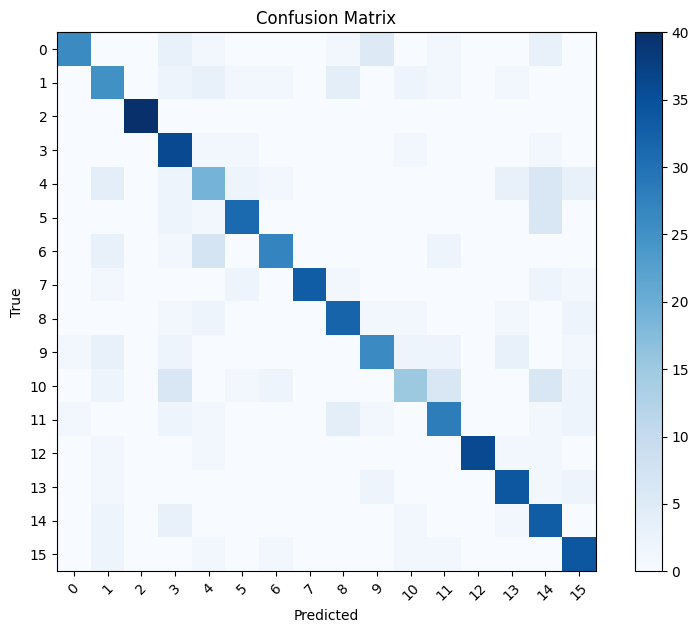

In [47]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from matplotlib import pyplot as plt

# Assuming you have implemented the training_dataloader_from_df function
test_dataloader = training_dataloader_from_df(test_data)

# Move the data loader to GPU if available
if torch.cuda.is_available():
    model.to('cuda')
    for batch in test_dataloader:
        for key in batch:
            batch[key] = batch[key].to('cuda')

# Evaluate on the test set
model.eval()
all_predictions = []
all_labels = []

for batch in tqdm(test_dataloader):
    with torch.no_grad():
        outputs = model(**batch)

    predictions = outputs.logits.argmax(-1).cpu().numpy()
    labels = batch['labels'].cpu().numpy()

    all_predictions.extend(predictions)
    all_labels.extend(labels)

# Convert lists to numpy arrays for sklearn metrics
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
accuracy = accuracy_score(all_labels, all_predictions)

print("Confusion Matrix:\n", conf_matrix)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks, rotation=45)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [48]:
query = 'C:\\Users\\Kounen Fathima\\Downloads\\test\\email\\71108803.tif'
image = Image.open(query).convert("RGB")
encoded_inputs = processor(image, return_tensors="pt").to(device)
outputs = model(**encoded_inputs)
preds = torch.softmax(outputs.logits, dim=1).tolist()[0]
pred_labels = {label:pred for label, pred in zip(label2idx.keys(), preds)}
pred_labels

{'advertisement': 0.00010895362356677651,
 'budget': 0.0002704743528738618,
 'email': 0.9875890612602234,
 'file_folder': 0.0012381206033751369,
 'form': 0.0005722146015614271,
 'handwritten': 0.00018406740855425596,
 'invoice': 0.00021783066040370613,
 'letter': 0.0010566110722720623,
 'memo': 0.0021863558795303106,
 'news_article': 0.00038617505924776196,
 'presentation': 0.0005670240498147905,
 'questionnaire': 0.0004562579561024904,
 'resume': 0.0015948540531098843,
 'scientific_publication': 0.0004655859956983477,
 'scientific_report': 0.000567960029002279,
 'specification': 0.002538397442549467}

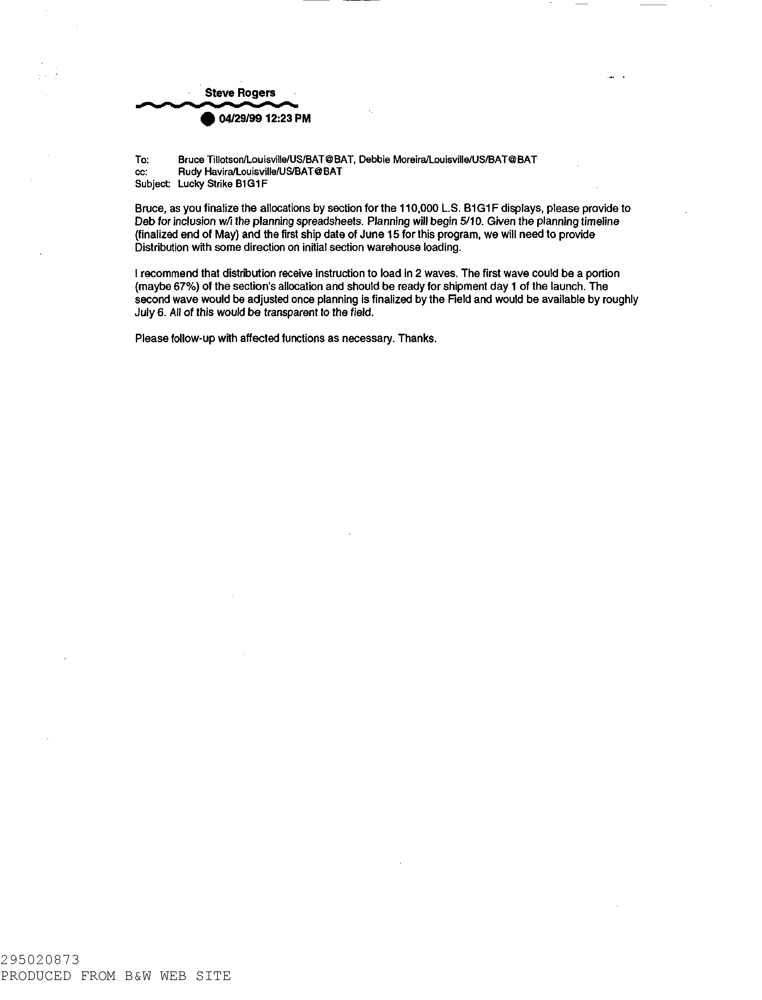

In [49]:
image

In [50]:
# Precision, Recall, F-score, Support
precision, recall, fscore, support = precision_recall_fscore_support(all_labels, all_predictions)

# Accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display precision, recall, f-score for each class
for label, prec, rec, fs, sup in zip(label2idx.keys(), precision, recall, fscore, support):
    print(f"\nClass: {label}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {fs:.4f}")
    print(f"Support: {sup}")


Accuracy: 74.22%

Class: advertisement
Precision: 0.9286
Recall: 0.6500
F1-score: 0.7647
Support: 40

Class: budget
Precision: 0.5682
Recall: 0.6250
F1-score: 0.5952
Support: 40

Class: email
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
Support: 40

Class: file_folder
Precision: 0.6000
Recall: 0.9000
F1-score: 0.7200
Support: 40

Class: form
Precision: 0.5135
Recall: 0.4750
F1-score: 0.4935
Support: 40

Class: handwritten
Precision: 0.8158
Recall: 0.7750
F1-score: 0.7949
Support: 40

Class: invoice
Precision: 0.8438
Recall: 0.6750
F1-score: 0.7500
Support: 40

Class: letter
Precision: 1.0000
Recall: 0.8250
F1-score: 0.9041
Support: 40

Class: memo
Precision: 0.7619
Recall: 0.8000
F1-score: 0.7805
Support: 40

Class: news_article
Precision: 0.7429
Recall: 0.6500
F1-score: 0.6933
Support: 40

Class: presentation
Precision: 0.6522
Recall: 0.3750
F1-score: 0.4762
Support: 40

Class: questionnaire
Precision: 0.6829
Recall: 0.7000
F1-score: 0.6914
Support: 40

Class: resume
Precision: 1

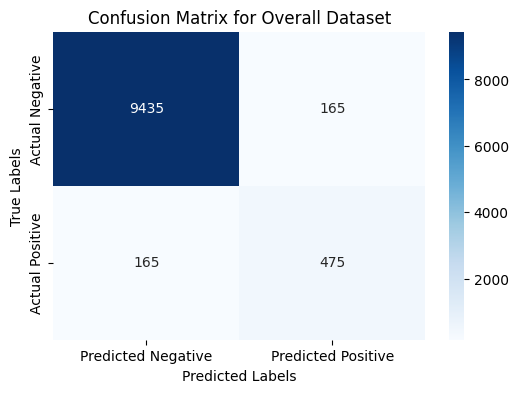

In [51]:
import seaborn as sns
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Extract TP, TN, FP, FN counts
tp = np.diag(conf_matrix)
fp = np.sum(conf_matrix, axis=0) - tp
fn = np.sum(conf_matrix, axis=1) - tp
tn = np.sum(conf_matrix) - (tp + fp + fn)

# Construct a new confusion matrix
conf_matrix_agg = np.array([[tn.sum(), fp.sum()], [fn.sum(), tp.sum()]])

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_agg, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Overall Dataset")
plt.show()

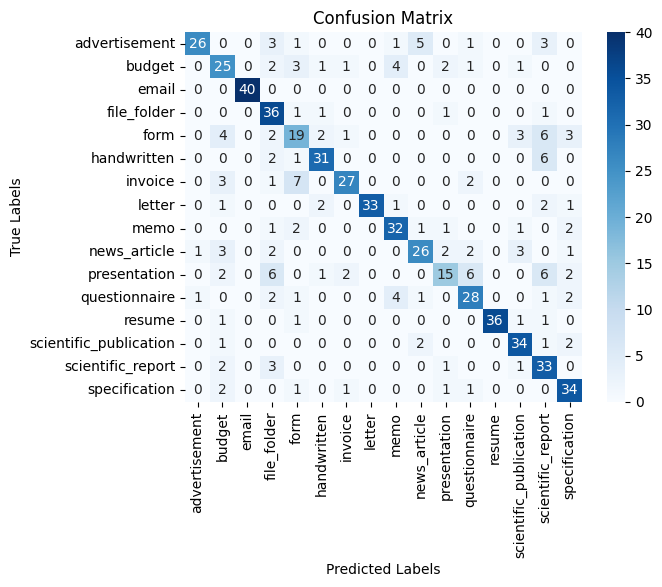

In [52]:
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label2idx.keys(), yticklabels=label2idx.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

100%|██████████| 160/160 [00:21<00:00,  7.46it/s]


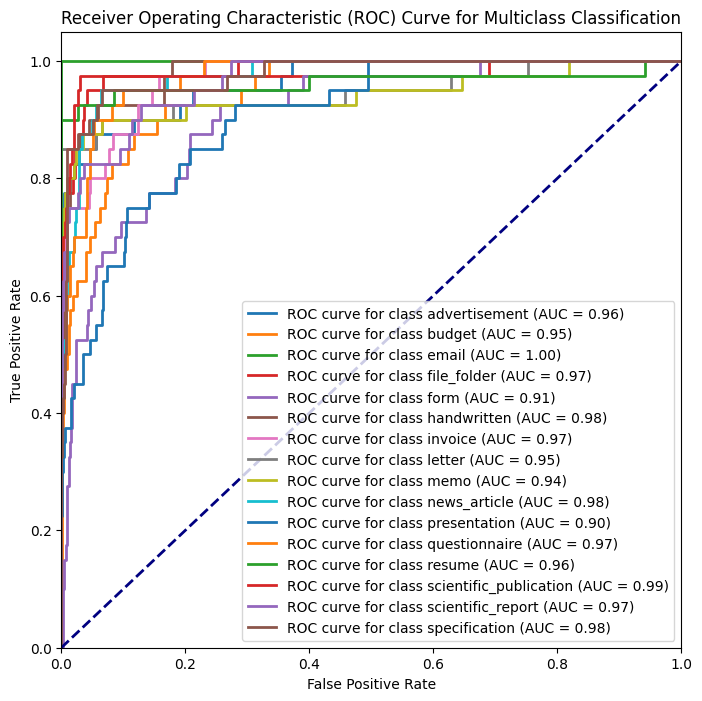

In [53]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


model.eval()
all_probabilities = []
all_labels = []

for batch in tqdm(test_dataloader):
    with torch.no_grad():
        outputs = model(**batch)

    probabilities = torch.softmax(outputs.logits, dim=1).cpu().numpy()
    labels = batch['labels'].cpu().numpy()

    all_probabilities.append(probabilities)
    all_labels.append(labels)

# Concatenate the lists to create arrays
all_probabilities = np.concatenate(all_probabilities, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Binarize the labels
all_labels_binary = label_binarize(all_labels, classes=np.arange(len(label2idx)))

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label2idx)):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binary[:, i], all_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 8))

for i in range(len(label2idx)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for class {idx2label[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()


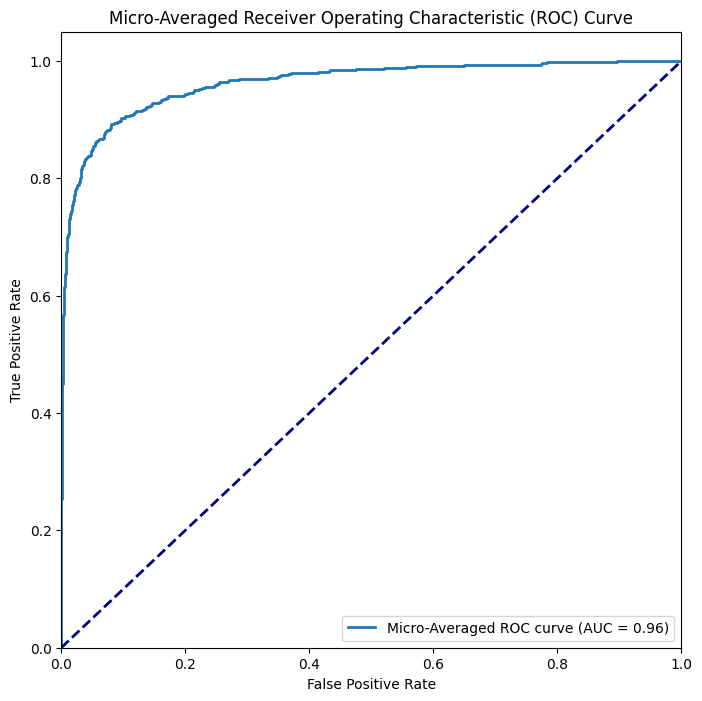

In [54]:
from sklearn.metrics import roc_curve, auc
# Compute micro-averaged ROC curve
fpr_micro, tpr_micro, _ = roc_curve(all_labels_binary.ravel(), all_probabilities.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot the ROC curve for overall accuracy
plt.figure(figsize=(8, 8))
plt.plot(fpr_micro, tpr_micro, lw=2, label=f'Micro-Averaged ROC curve (AUC = {roc_auc_micro:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Averaged Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
